# 04 - Synthetic Dataset Generation Exploration

This notebook explores strategies for generating synthetic variations of the golden dataset.

**Goal**: Scale from 50 base examples to 5000 total examples by creating ~100 variations per base example.

**Key Constraint**: The `expected_json` must remain unchanged across all variations of a base example.

In [1]:
import json
import random
from pathlib import Path
from bs4 import BeautifulSoup
import pandas as pd
from typing import List, Dict, Any

## 1. Load Golden Dataset

In [2]:
# Load golden dataset
golden_path = Path("../data/processed/golden.jsonl")

golden_examples = []
with open(golden_path, "r", encoding="utf-8") as f:
    for line in f:
        golden_examples.append(json.loads(line))

print(f"Loaded {len(golden_examples)} golden examples")
print(f"Target: {len(golden_examples) * 100} synthetic examples (100 variations each)")

Loaded 47 golden examples
Target: 4700 synthetic examples (100 variations each)


## 2. Inspect Base Example Structure

In [3]:
# Look at a single example
example = golden_examples[0]

print("Keys:", example.keys())
print("\nExpected JSON schema:")
print(json.dumps(example["expected_json"], indent=2))
print("\nHTML length:", len(example["example_html"]), "characters")

Keys: dict_keys(['example_html', 'expected_json'])

Expected JSON schema:
{
  "url": "https://10coins.io/products/",
  "title": "10coins - New generation crypto payment gateway",
  "text": "10coins - New generation crypto payment gateway\n[10coins](https://10coins.io/)\n[Get Started](https://10coins.io/contact/)\n# Products\n360 solution offering great UX, unique features and full back\nend-control.\n[Get Started](https://10coins.io/contact/)\n## Risk\nmanagement system\nBuilt-in Risk management tool and set of alerts which will allow you identify risky transactions and set automatic actions within the platform\n\n## Invoicing\nBuilt-in invoicing system which presents all deposits and payouts with all their details in order to provide your end users all the information they on their transactions.\n\n## Over/Under payments Acceptance system\nBuilt-in predefined mechanism which will allow you to determine which transactions to accept in case a different amount was transferred by end user

In [4]:
# Parse HTML to understand structure
soup = BeautifulSoup(example["example_html"], "html.parser")

print("HTML structure overview:")
print(f"- Title tag: {soup.title.string if soup.title else 'None'}")
print(f"- Body exists: {soup.body is not None}")
print(f"- Number of divs: {len(soup.find_all('div'))}")
print(f"- Number of paragraphs: {len(soup.find_all('p'))}")
print(f"- Number of links: {len(soup.find_all('a'))}")
print(f"- Number of headings: {len(soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6']))}")

HTML structure overview:
- Title tag: 10coins - New generation crypto payment gateway
- Body exists: True
- Number of divs: 68
- Number of paragraphs: 5
- Number of links: 14
- Number of headings: 5


## 3. Augmentation Strategy 1: Structural Variations

Add wrapper divs, change nesting depth, insert empty elements

In [5]:
def add_wrapper_divs(html: str, num_wrappers: int = 1) -> str:
    """
    Wrap the <body> content in additional div layers.
    """
    soup = BeautifulSoup(html, "html.parser")
    
    if soup.body:
        # Get body contents
        body_contents = list(soup.body.children)
        
        # Create nested wrappers
        current_wrapper = soup.body
        for i in range(num_wrappers):
            new_div = soup.new_tag("div")
            new_div["class"] = [f"wrapper-{i}"]
            current_wrapper.clear()
            current_wrapper.append(new_div)
            current_wrapper = new_div
        
        # Move original contents to innermost wrapper
        for child in body_contents:
            current_wrapper.append(child)
    
    return str(soup)

# Test wrapper variation
test_html = example["example_html"]
wrapped = add_wrapper_divs(test_html, num_wrappers=2)

print(f"Original HTML length: {len(test_html)}")
print(f"Wrapped HTML length: {len(wrapped)}")
print(f"Difference: +{len(wrapped) - len(test_html)} characters")

Original HTML length: 27237
Wrapped HTML length: 27363
Difference: +126 characters


## 4. Augmentation Strategy 2: Attribute Noise

Add random classes, IDs, data attributes to existing elements

In [6]:
def add_random_attributes(html: str, probability: float = 0.3) -> str:
    """
    Add random attributes to elements with given probability.
    """
    soup = BeautifulSoup(html, "html.parser")
    
    # Random class names and data attributes
    random_classes = [
        "container", "wrapper", "content", "main", "section",
        "item", "block", "element", "component", "module"
    ]
    
    # Find all tags
    for tag in soup.find_all(True):
        if random.random() < probability:
            # Add random class
            if "class" in tag.attrs:
                tag["class"].append(random.choice(random_classes))
            else:
                tag["class"] = [random.choice(random_classes)]
        
        if random.random() < probability * 0.5:
            # Add random data attribute
            tag[f"data-{random.choice(['id', 'key', 'index', 'type'])}"] = f"value-{random.randint(1, 1000)}"
    
    return str(soup)

# Test attribute noise
noisy = add_random_attributes(test_html, probability=0.2)

print(f"Original HTML length: {len(test_html)}")
print(f"Noisy HTML length: {len(noisy)}")
print(f"Difference: +{len(noisy) - len(test_html)} characters")

Original HTML length: 27237
Noisy HTML length: 27929
Difference: +692 characters


## 5. Augmentation Strategy 3: Style Injection

Add inline styles, CSS comments, empty style tags

In [7]:
def inject_style_noise(html: str, probability: float = 0.2) -> str:
    """
    Inject random inline styles and style elements.
    """
    soup = BeautifulSoup(html, "html.parser")
    
    # Random harmless styles
    random_styles = [
        "display: block",
        "margin: 0",
        "padding: 0",
        "position: relative",
        "box-sizing: border-box"
    ]
    
    # Add inline styles to random elements
    for tag in soup.find_all(True):
        if random.random() < probability:
            if "style" in tag.attrs:
                tag["style"] += "; " + random.choice(random_styles)
            else:
                tag["style"] = random.choice(random_styles)
    
    return str(soup)

# Test style injection
styled = inject_style_noise(test_html, probability=0.15)

print(f"Original HTML length: {len(test_html)}")
print(f"Styled HTML length: {len(styled)}")
print(f"Difference: +{len(styled) - len(test_html)} characters")

Original HTML length: 27237
Styled HTML length: 27939
Difference: +702 characters


## 6. Augmentation Strategy 4: HTML Comments

Inject HTML comments throughout the document

In [8]:
def inject_comments(html: str, num_comments: int = 5) -> str:
    """
    Inject random HTML comments.
    """
    soup = BeautifulSoup(html, "html.parser")
    
    comment_templates = [
        "Start of section",
        "End of section",
        "TODO: refactor this",
        "Generated by framework",
        "Container element",
    ]
    
    # Find random insertion points
    all_tags = soup.find_all(True)
    if len(all_tags) > 0:
        for _ in range(min(num_comments, len(all_tags))):
            tag = random.choice(all_tags)
            comment_text = random.choice(comment_templates)
            from bs4 import Comment
            comment = Comment(f" {comment_text} ")
            tag.insert(0, comment)
    
    return str(soup)

# Test comment injection
commented = inject_comments(test_html, num_comments=10)

print(f"Original HTML length: {len(test_html)}")
print(f"Commented HTML length: {len(commented)}")
print(f"Difference: +{len(commented) - len(test_html)} characters")

Original HTML length: 27237
Commented HTML length: 27569
Difference: +332 characters


## 7. Augmentation Strategy 5: Whitespace Variations

Change indentation, add/remove newlines, modify spacing

In [9]:
def vary_whitespace(html: str, prettify: bool = None) -> str:
    """
    Vary whitespace formatting.
    If prettify is None, randomly choose.
    """
    soup = BeautifulSoup(html, "html.parser")
    
    if prettify is None:
        prettify = random.choice([True, False])
    
    if prettify:
        return soup.prettify()
    else:
        # Minify (remove extra whitespace)
        return str(soup)

# Test whitespace variation
prettified = vary_whitespace(test_html, prettify=True)
minified = vary_whitespace(test_html, prettify=False)

print(f"Original HTML length: {len(test_html)}")
print(f"Prettified HTML length: {len(prettified)}")
print(f"Minified HTML length: {len(minified)}")

Original HTML length: 27237
Prettified HTML length: 31481
Minified HTML length: 27305


## 8. Combined Augmentation Pipeline

Combine multiple strategies to create diverse variations

In [10]:
def generate_variation(html: str, variation_id: int) -> str:
    """
    Generate a single synthetic variation.
    Randomly apply different augmentation strategies.
    """
    # Set seed for reproducibility based on variation_id
    random.seed(variation_id)
    
    result = html
    
    # Randomly apply augmentations
    if random.random() < 0.4:
        result = add_wrapper_divs(result, num_wrappers=random.randint(1, 3))
    
    if random.random() < 0.6:
        result = add_random_attributes(result, probability=random.uniform(0.1, 0.3))
    
    if random.random() < 0.3:
        result = inject_style_noise(result, probability=random.uniform(0.05, 0.2))
    
    if random.random() < 0.4:
        result = inject_comments(result, num_comments=random.randint(3, 10))
    
    if random.random() < 0.5:
        result = vary_whitespace(result)
    
    # Reset random seed
    random.seed()
    
    return result

# Test combined pipeline
test_variations = []
for i in range(5):
    variation = generate_variation(test_html, variation_id=i)
    test_variations.append(variation)
    print(f"Variation {i}: {len(variation)} characters (+{len(variation) - len(test_html)} vs original)")

Variation 0: 27578 characters (+341 vs original)
Variation 1: 28662 characters (+1425 vs original)
Variation 2: 28048 characters (+811 vs original)
Variation 3: 34158 characters (+6921 vs original)
Variation 4: 27411 characters (+174 vs original)


## 9. Generate Full Synthetic Dataset

Create 100 variations per base example

In [11]:
def generate_synthetic_dataset(
    golden_examples: List[Dict[str, Any]],
    variations_per_example: int = 100
) -> List[Dict[str, Any]]:
    """
    Generate synthetic dataset from golden examples.
    """
    synthetic_examples = []
    
    for base_idx, base_example in enumerate(golden_examples):
        base_html = base_example["example_html"]
        expected_json = base_example["expected_json"]
        
        # Include the original as variation 0
        synthetic_examples.append({
            "example_html": base_html,
            "expected_json": expected_json,
            "base_id": base_idx,
            "variation_id": 0
        })
        
        # Generate variations
        for var_idx in range(1, variations_per_example):
            # Create unique seed combining base and variation IDs
            variation_seed = base_idx * 1000 + var_idx
            varied_html = generate_variation(base_html, variation_id=variation_seed)
            
            synthetic_examples.append({
                "example_html": varied_html,
                "expected_json": expected_json,  # UNCHANGED!
                "base_id": base_idx,
                "variation_id": var_idx
            })
        
        if (base_idx + 1) % 10 == 0:
            print(f"Processed {base_idx + 1}/{len(golden_examples)} base examples...")
    
    return synthetic_examples

# Generate small test set (5 base examples, 10 variations each)
print("Generating test synthetic dataset...")
test_synthetic = generate_synthetic_dataset(golden_examples[:5], variations_per_example=10)
print(f"\nGenerated {len(test_synthetic)} synthetic examples from 5 base examples")

Generating test synthetic dataset...

Generated 50 synthetic examples from 5 base examples


## 10. Validate Synthetic Examples

Ensure expected_json is preserved and HTML is valid

In [12]:
def validate_synthetic_dataset(synthetic_examples: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Validate synthetic dataset quality.
    """
    validation_results = {
        "total_examples": len(synthetic_examples),
        "unique_base_examples": len(set(ex["base_id"] for ex in synthetic_examples)),
        "parseable_html": 0,
        "valid_json_schema": 0,
        "expected_json_preserved": 0
    }
    
    # Required Exa schema fields
    required_fields = {"url", "title", "text", "author", "published_date", "image", "favicon", "id"}
    
    # Group by base_id to check expected_json consistency
    by_base = {}
    for ex in synthetic_examples:
        base_id = ex["base_id"]
        if base_id not in by_base:
            by_base[base_id] = []
        by_base[base_id].append(ex)
    
    for base_id, variations in by_base.items():
        # Get the expected_json from variation 0
        expected = variations[0]["expected_json"]
        
        # Check all variations have the same expected_json
        all_same = all(
            json.dumps(var["expected_json"], sort_keys=True) == json.dumps(expected, sort_keys=True)
            for var in variations
        )
        
        if all_same:
            validation_results["expected_json_preserved"] += len(variations)
    
    # Validate HTML parseability and JSON schema
    for ex in synthetic_examples:
        # Try parsing HTML
        try:
            soup = BeautifulSoup(ex["example_html"], "html.parser")
            if soup:
                validation_results["parseable_html"] += 1
        except Exception:
            pass
        
        # Check JSON schema
        json_obj = ex["expected_json"]
        if isinstance(json_obj, dict) and required_fields.issubset(json_obj.keys()):
            validation_results["valid_json_schema"] += 1
    
    return validation_results

# Validate test set
validation = validate_synthetic_dataset(test_synthetic)
print(json.dumps(validation, indent=2))

print("\nValidation Summary:")
print(f"- HTML parseability: {validation['parseable_html']}/{validation['total_examples']} ({100*validation['parseable_html']/validation['total_examples']:.1f}%)")
print(f"- JSON schema valid: {validation['valid_json_schema']}/{validation['total_examples']} ({100*validation['valid_json_schema']/validation['total_examples']:.1f}%)")
print(f"- Expected JSON preserved: {validation['expected_json_preserved']}/{validation['total_examples']} ({100*validation['expected_json_preserved']/validation['total_examples']:.1f}%)")

{
  "total_examples": 50,
  "unique_base_examples": 5,
  "parseable_html": 50,
  "valid_json_schema": 50,
  "expected_json_preserved": 50
}

Validation Summary:
- HTML parseability: 50/50 (100.0%)
- JSON schema valid: 50/50 (100.0%)
- Expected JSON preserved: 50/50 (100.0%)


## 11. Dataset Statistics

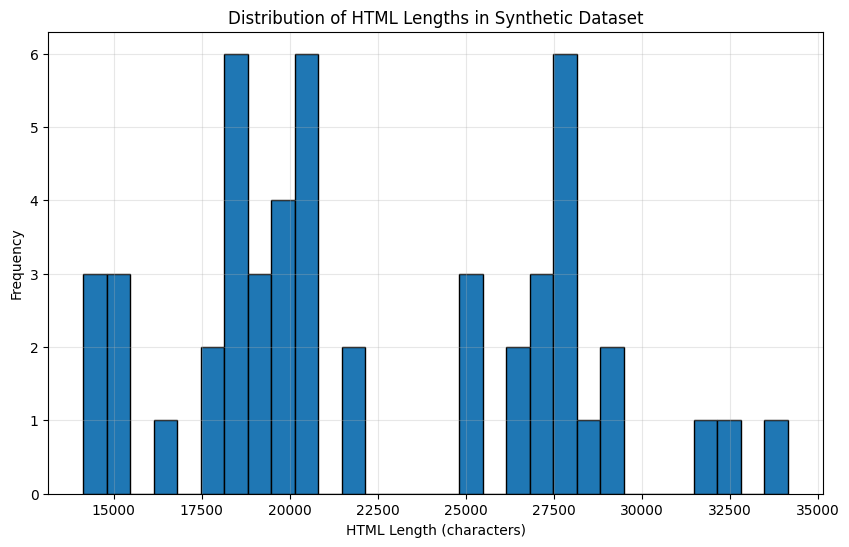

HTML Length Statistics:
- Min: 14,142 characters
- Max: 34,158 characters
- Mean: 22,340 characters
- Median: 20,582 characters


In [13]:
# Analyze HTML length distribution
html_lengths = [len(ex["example_html"]) for ex in test_synthetic]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(html_lengths, bins=30, edgecolor='black')
plt.xlabel('HTML Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of HTML Lengths in Synthetic Dataset')
plt.grid(True, alpha=0.3)
plt.show()

print(f"HTML Length Statistics:")
print(f"- Min: {min(html_lengths):,} characters")
print(f"- Max: {max(html_lengths):,} characters")
print(f"- Mean: {sum(html_lengths)/len(html_lengths):,.0f} characters")
print(f"- Median: {sorted(html_lengths)[len(html_lengths)//2]:,} characters")

## 12. Save Test Synthetic Dataset

In [14]:
# Save test synthetic dataset
output_dir = Path("../data/synthetic")
output_dir.mkdir(parents=True, exist_ok=True)

test_output = output_dir / "test_synthetic.jsonl"

with open(test_output, "w", encoding="utf-8") as f:
    for example in test_synthetic:
        # Remove metadata fields before saving
        clean_example = {
            "example_html": example["example_html"],
            "expected_json": example["expected_json"]
        }
        f.write(json.dumps(clean_example, ensure_ascii=False) + "\n")

print(f"Saved test synthetic dataset to: {test_output}")
print(f"Total examples: {len(test_synthetic)}")

Saved test synthetic dataset to: ../data/synthetic/test_synthetic.jsonl
Total examples: 50


## Next Steps

1. ✅ Validated augmentation strategies work correctly
2. ✅ Confirmed expected_json is preserved across variations
3. ⏳ Generate full 5000-example dataset (implement in `04_generate.py`)
4. ⏳ Create train/val/test splits (80/10/10)
5. ⏳ Export to HuggingFace format for fine-tuning

**Implementation Plan**:
- Move the augmentation functions to `04_generate.py`
- Add CLI arguments for customization (num_variations, output_path, etc.)
- Add progress bars with tqdm
- Implement train/val/test splitting logic
- Add comprehensive validation reporting